In [1]:
import multimodal_cci as mmcci
import scanpy as sc
import numpy as np

#### Load stLearn data objects

In [2]:
brain_aged_tech1 = [
    sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP40_1C_CCI.h5ad"),
    sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP40_1D_CCI.h5ad"),
    sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP41_1B_CCI.h5ad"),
    sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP41_1D_CCI.h5ad")
    ]

brain_young_tech1 = [
    sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP40_1A_CCI.h5ad"),
    sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP40_1B_CCI.h5ad"),
    sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP41_1A_CCI.h5ad"),
    sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP41_1C_CCI.h5ad")
    ]

brain_aged_tech2 = [
    sc.read_h5ad("/QRISdata/Q5058/sMACS/STomics/Processed/Brain/CCI_new/brain_A1_CCI_bin80.h5ad"),
    sc.read_h5ad("/QRISdata/Q5058/sMACS/STomics/Processed/Brain/CCI_new/brain_A4_CCI_bin80.h5ad")
    ]
brain_young_tech2 = [
    sc.read_h5ad("/QRISdata/Q5058/sMACS/STomics/Processed/Brain/CCI_new/brain_Y1_CCI_bin80.h5ad"),
    sc.read_h5ad("/QRISdata/Q5058/sMACS/STomics/Processed/Brain/CCI_new/brain_Y4_CCI_bin80.h5ad")
    ]

brain_aged_tech1_cci = [sample.uns['per_lr_cci_cell_type'] for sample in brain_aged_tech1]
brain_young_tech1_cci = [sample.uns['per_lr_cci_cell_type'] for sample in brain_young_tech1]
brain_aged_tech2_cci = [sample.uns['per_lr_cci_cell_type'] for sample in brain_aged_tech2]
brain_young_tech2_cci = [sample.uns['per_lr_cci_cell_type'] for sample in brain_young_tech2]

brain_aged_tech1_sizes = [sample.shape[0] for sample in brain_aged_tech1]
brain_young_tech1_sizes = [sample.shape[0] for sample in brain_young_tech1]
brain_aged_tech2_sizes = [sample.shape[0] for sample in brain_aged_tech2]
brain_young_tech2_sizes = [sample.shape[0] for sample in brain_young_tech2]

#### Normalise each group of samples

In [3]:
brain_aged_tech1_normalised = mmcci.it.normalise_samples_to_target(brain_aged_tech1_cci, brain_aged_tech1_sizes, target=brain_young_tech1_sizes[0])
brain_young_tech1_normalised = mmcci.it.normalise_samples_to_target(brain_young_tech1_cci, brain_young_tech1_sizes, target=brain_young_tech1_sizes[0])
brain_aged_tech2_normalised = mmcci.it.normalise_samples_to_target(brain_aged_tech2_cci, brain_aged_tech2_sizes, target=brain_young_tech2_sizes[0])
brain_young_tech2_normalised = mmcci.it.normalise_samples_to_target(brain_young_tech2_cci, brain_young_tech2_sizes, target=brain_young_tech2_sizes[0])

#### Subset to only LR pairs present in majority of samples

In [4]:
aged_tech1_lr_pairs = mmcci.it.get_majority_lr_pairs(brain_aged_tech1_normalised)
aged_tech2_lr_pairs = mmcci.it.get_majority_lr_pairs(brain_aged_tech2_normalised)
young_tech1_lr_pairs = mmcci.it.get_majority_lr_pairs(brain_aged_tech1_normalised)
young_tech2_lr_pairs = mmcci.it.get_majority_lr_pairs(brain_young_tech2_normalised)

#### Calculate average value of each LR pair across each group

In [5]:
brain_aged_tech1_avg = mmcci.it.get_avg_lr_pairs(brain_aged_tech1_normalised, aged_tech1_lr_pairs)
brain_aged_tech2_avg = mmcci.it.get_avg_lr_pairs(brain_aged_tech2_normalised, aged_tech2_lr_pairs)
brain_young_tech1_avg = mmcci.it.get_avg_lr_pairs(brain_young_tech1_normalised, young_tech1_lr_pairs)
brain_young_tech2_avg = mmcci.it.get_avg_lr_pairs(brain_young_tech2_normalised, young_tech2_lr_pairs)

#### Normalise samples between technologies

In [6]:
normalised = mmcci.it.normalise_samples_between_tech(
    [[brain_aged_tech1_avg, brain_young_tech1_avg],
     [brain_aged_tech2_avg, brain_young_tech2_avg]]
    )

#### Integrate between technologies for both groups

In [7]:
normalised = np.array(normalised).T.tolist() # Transpose to get lists of groups instead of techs
aged_integrated = mmcci.it.integrate_between_tech(normalised[0])
young_integrated = mmcci.it.integrate_between_tech(normalised[1])

#### Calculate overall interactions network per group

In [8]:
aged_overall = mmcci.it.calculate_overall_interactions(aged_integrated)
young_overall = mmcci.it.calculate_overall_interactions(young_integrated)

#### Rank LR pairs based on dissimilarity between groups

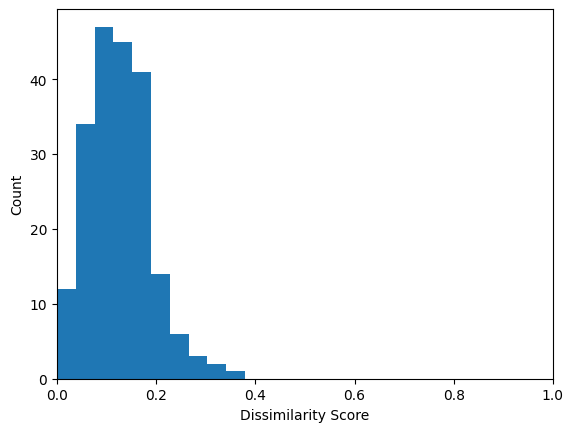

Overall Network Aged vs Young Dissimilarity Score is: 0.3824328605785001

Top 10 Dissimilar LR Pairs: ['A2m_Lrp1', 'Vim_Cd44', 'Apoe_Lrp8', 'Fgf2_Sdc4', 'Sema6d_Tyrobp', 'Mdk_Ptprz1', 'Mdk_Itgb1', 'Timp1_Cd63', 'Mdk_Itga6', 'Fgf2_Cd44']


In [9]:
dissimilarity_scores = mmcci.it.calculate_dissim(aged_integrated, young_integrated)
mmcci.plt.dissim_hist(dissimilarity_scores)
    
## Sort LR Pairs from high to low dissimilarities
print("Overall Network Aged vs Young Dissimilarity Score is: " + str(mmcci.sc.dissimilarity_score(aged_overall, young_overall)))

sorted_pairs = sorted(dissimilarity_scores, key=dissimilarity_scores.get, reverse=True)
print("\nTop 10 Dissimilar LR Pairs:", sorted_pairs[:10])

#### Plot highly dissimilar pairs between groups

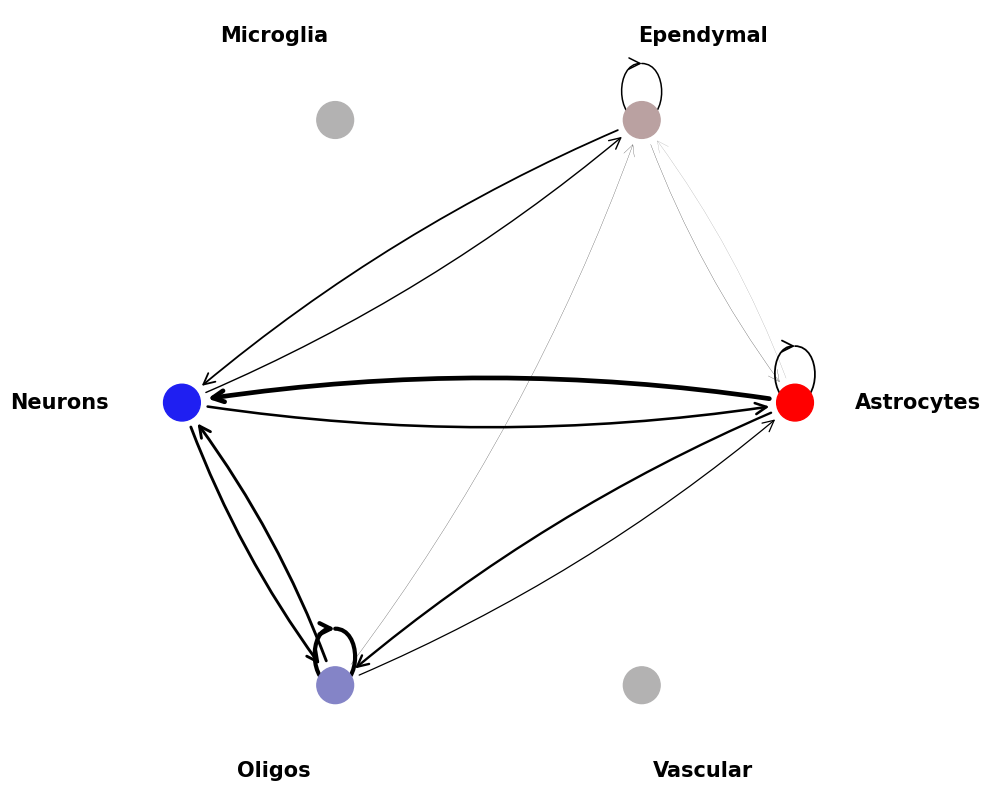

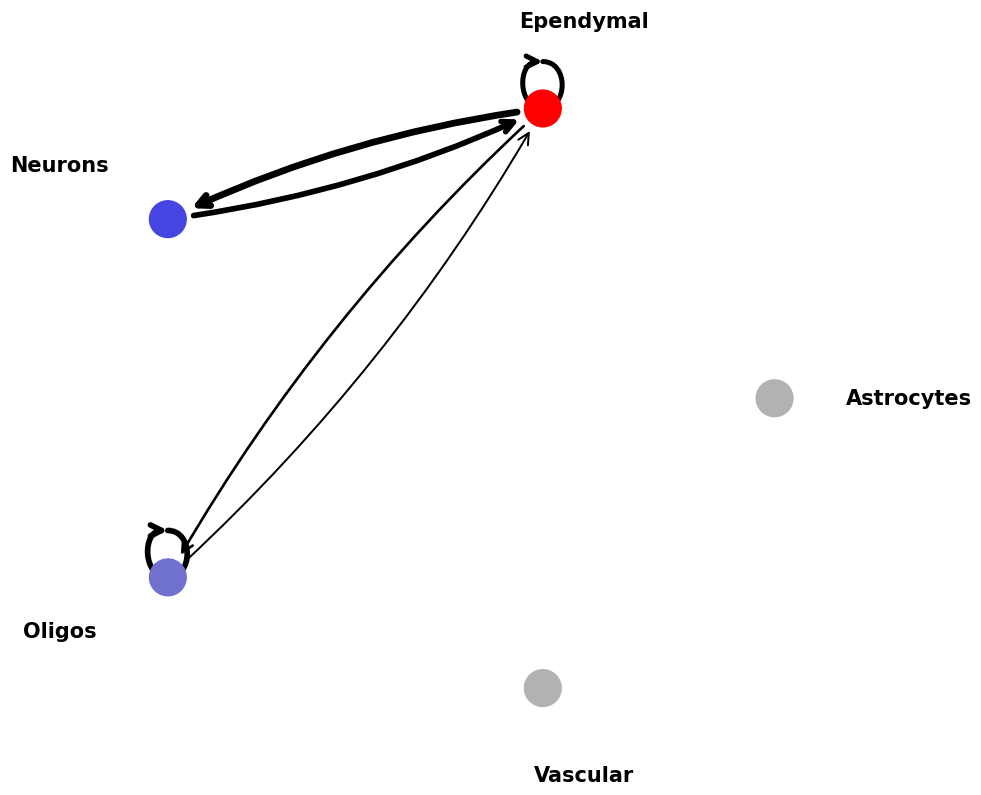

In [10]:
mmcci.plt.network_plot(aged_integrated['A2m_Lrp1'])
mmcci.plt.network_plot(young_integrated['A2m_Lrp1'])

#### Calculate p values for significance changes between groups

In [11]:
p_values = mmcci.sc.perm_test(aged_overall, young_overall)
p_values

,Astrocytes,Ependymal,Microglia,Neurons,Oligos,Vascular
Astrocytes,0.194185,0.457185,0.472050,0.208555,0.207770,0.470995
Ependymal,0.428220,0.055215,0.473175,0.221580,0.373195,0.471775
Microglia,0.474750,0.469840,0.472475,0.472190,0.472185,0.473190
Neurons,0.195385,0.194160,0.473380,0.055155,0.154470,0.475285
Oligos,0.277250,0.375675,0.469675,0.250835,0.013770,0.473030
Vascular,0.415400,0.472120,0.470790,0.416880,0.471175,0.473655


#### Plot aged and young overall networks

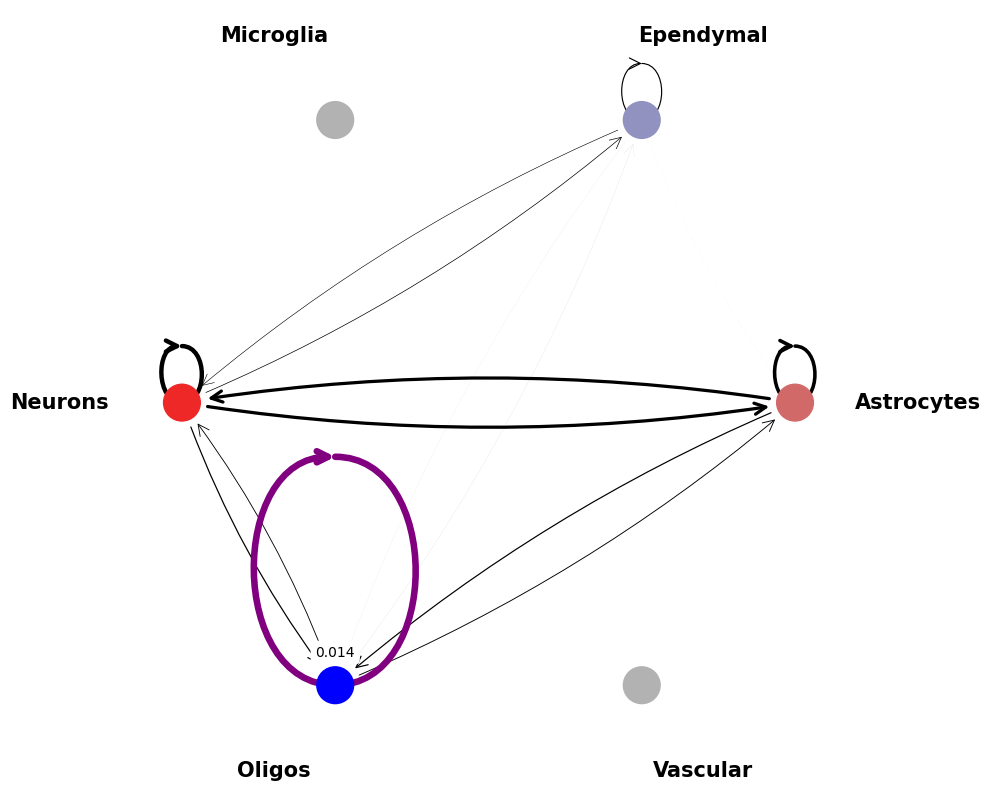

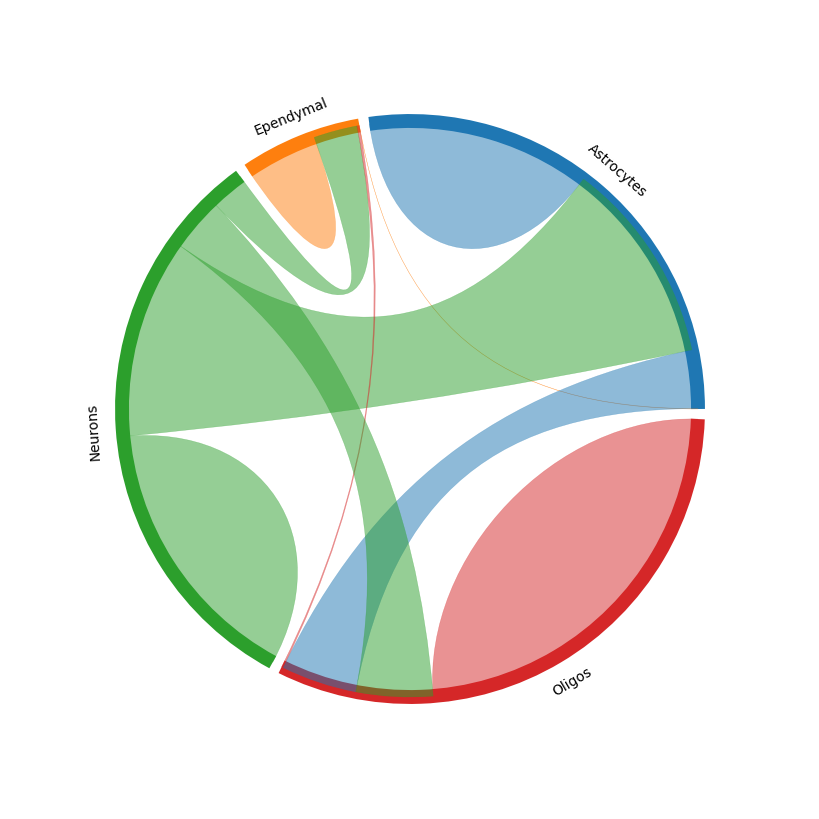

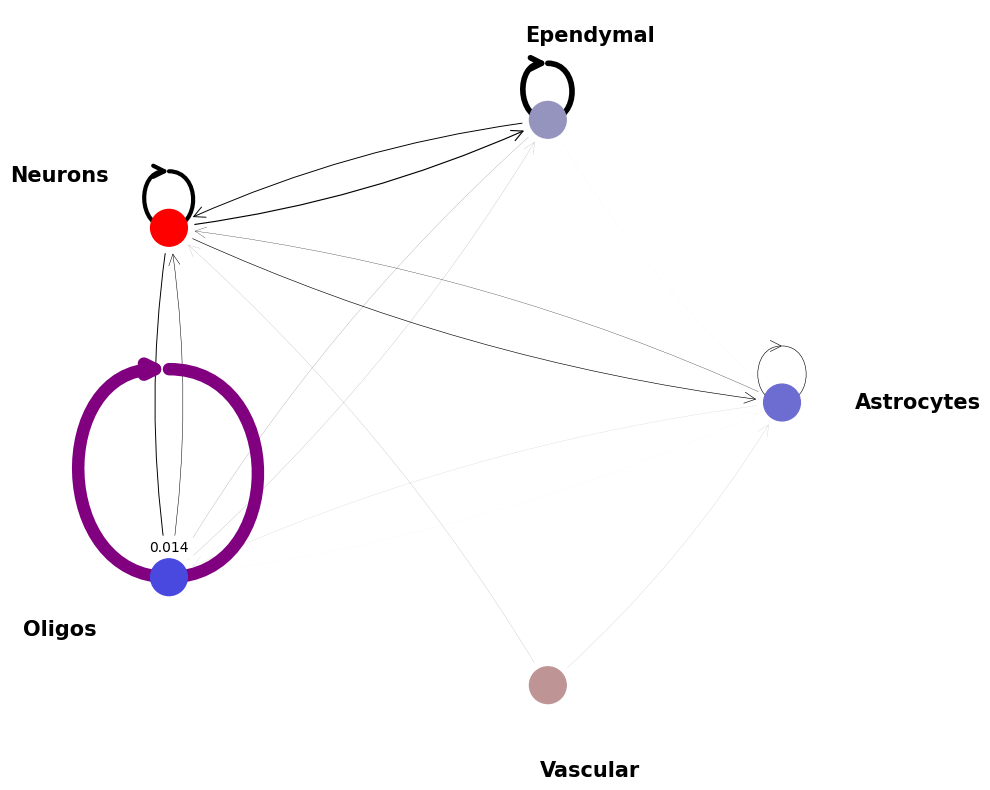

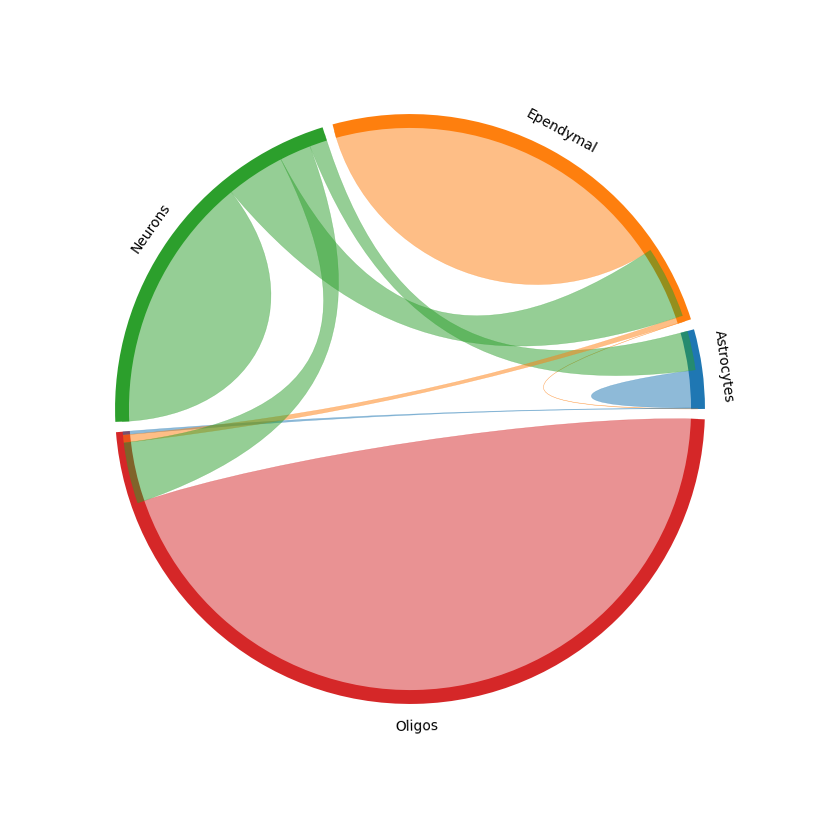

In [12]:
mmcci.plt.network_plot(aged_overall, p_values)
mmcci.plt.chord_plot(aged_overall)
mmcci.plt.network_plot(young_overall, p_values)
mmcci.plt.chord_plot(young_overall)

#### Get LR pairs from Vascular to Astrocytes

In [13]:
vasc_astr_lrs_aged = mmcci.it.get_lrs_per_celltype(aged_integrated, "Astrocytes", "Neurons")
print("LR pairs from vascular to astrocytes in aged")
print(vasc_astr_lrs_aged)
vasc_astr_lrs_young = mmcci.it.get_lrs_per_celltype(young_integrated, "Astrocytes", "Neurons")
print("\nLR pairs from vascular to astrocytes in young")
print(vasc_astr_lrs_young)

LR pairs from vascular to astrocytes in aged
{}

LR pairs from vascular to astrocytes in young
{'Serpinf1_Plxdc2': 1.0}


#### Cluster aged and young lr pairs

Computing Dissimilarity Scores ...


Processing: 100%|██████████| 252/252 [00:39<00:00,  6.32it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...


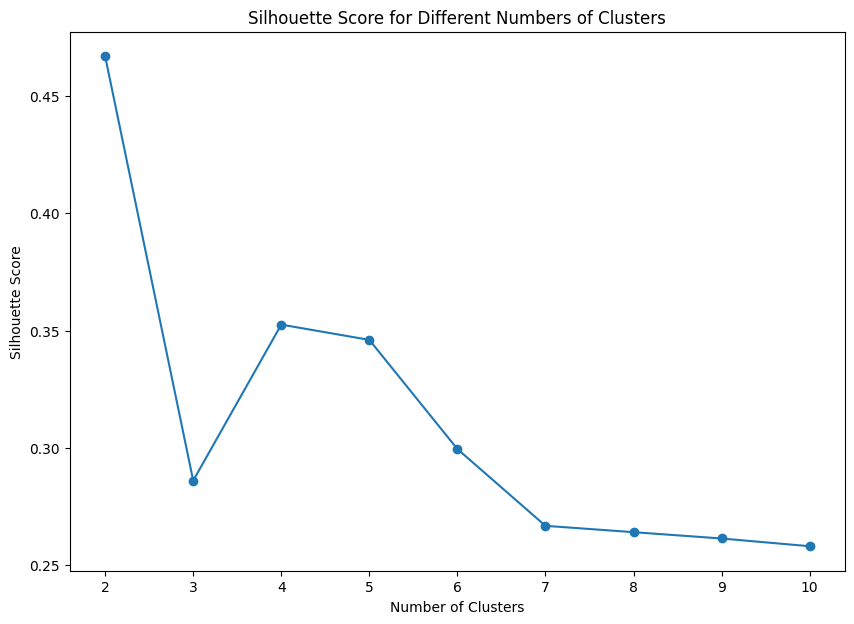

In [14]:
aged_clusters = mmcci.it.lr_clustering(aged_integrated, n_clusters=0)
aged_integrated_clusters = mmcci.it.subset_clusters(aged_integrated, aged_clusters)
aged_overall_clusters = mmcci.it.calculate_cluster_interactions(aged_integrated_clusters)


cluster0: Contains 232 LR pairs


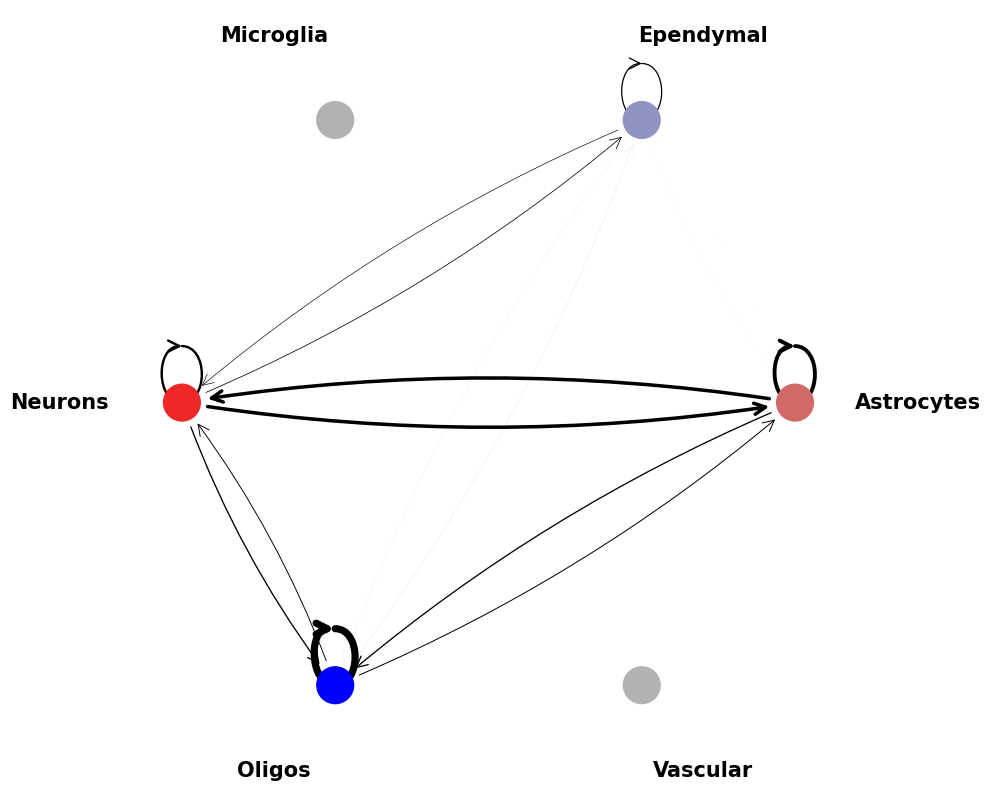


cluster1: Contains 20 LR pairs


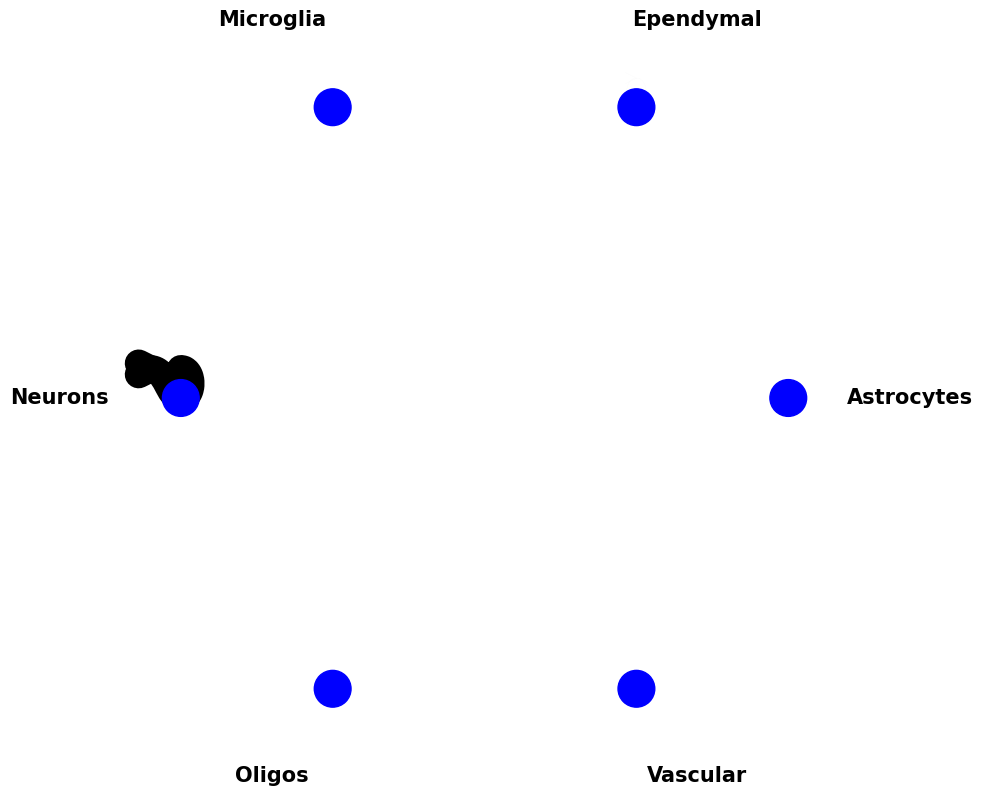

In [15]:
for cluster, matrix in aged_overall_clusters.items():
    print("\ncluster" + str(cluster) + ": Contains " + str(len(aged_integrated_clusters[cluster])) + " LR pairs")
    mmcci.plt.network_plot(matrix)

Computing Dissimilarity Scores ...


Processing: 100%|██████████| 186/186 [00:21<00:00,  8.72it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...


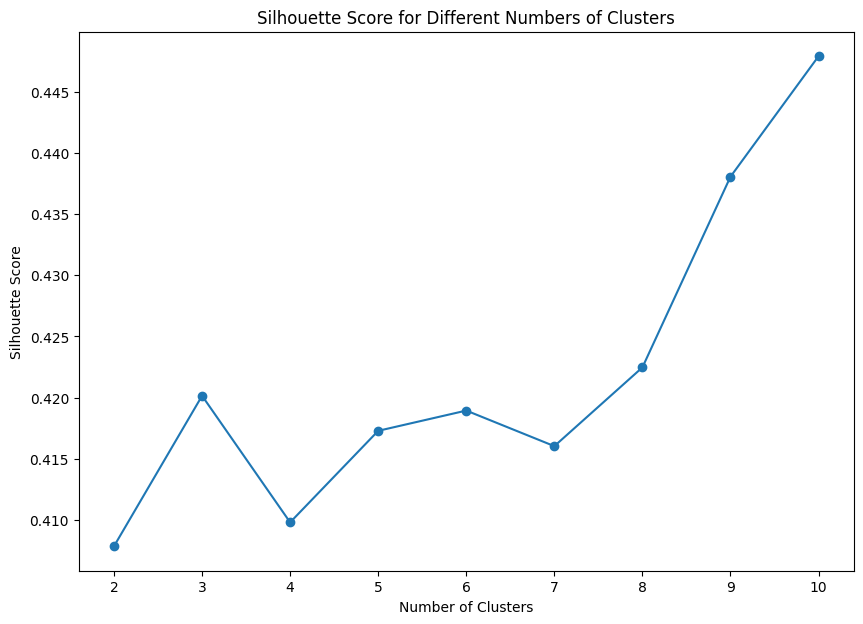

In [16]:
young_clusters = mmcci.it.lr_clustering(young_integrated, n_clusters=0)
young_integrated_clusters = mmcci.it.subset_clusters(young_integrated, young_clusters)
young_overall_clusters = mmcci.it.calculate_cluster_interactions(young_integrated_clusters)


cluster0: Contains 18 LR pairs


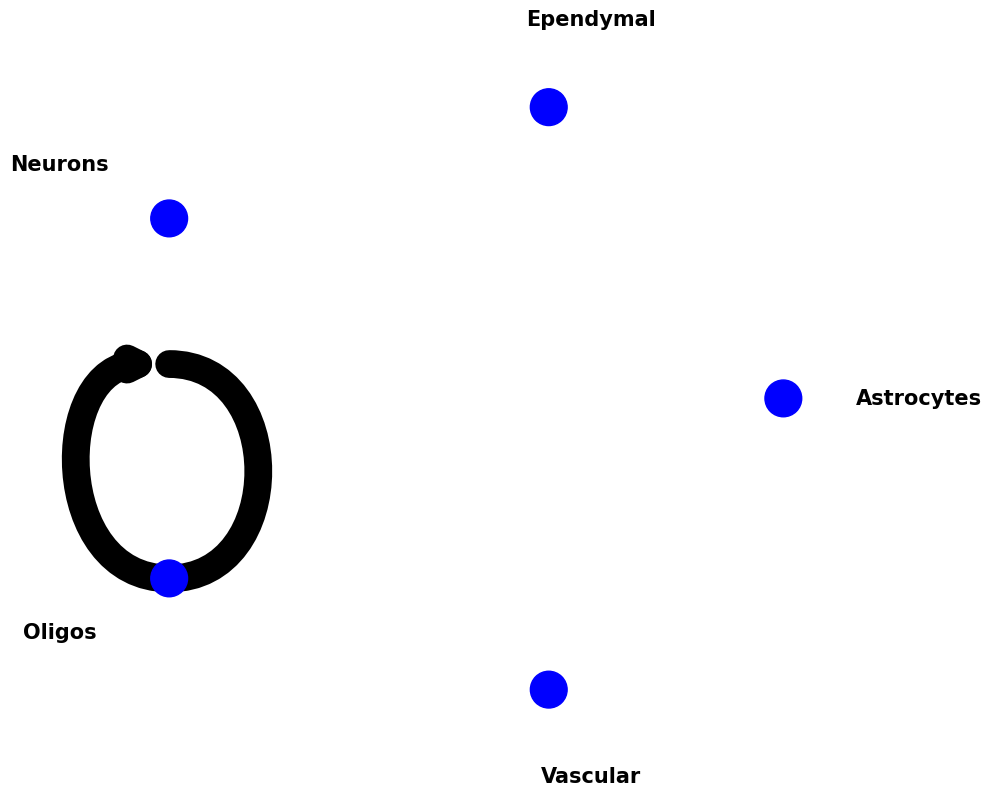


cluster1: Contains 23 LR pairs


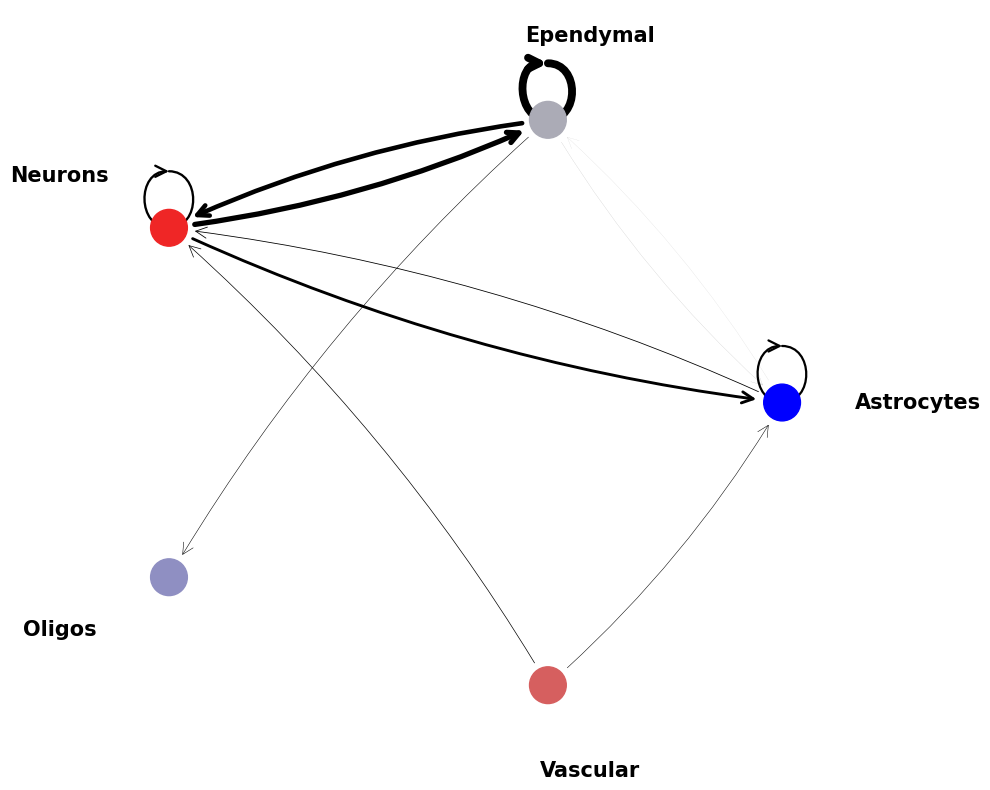


cluster2: Contains 22 LR pairs


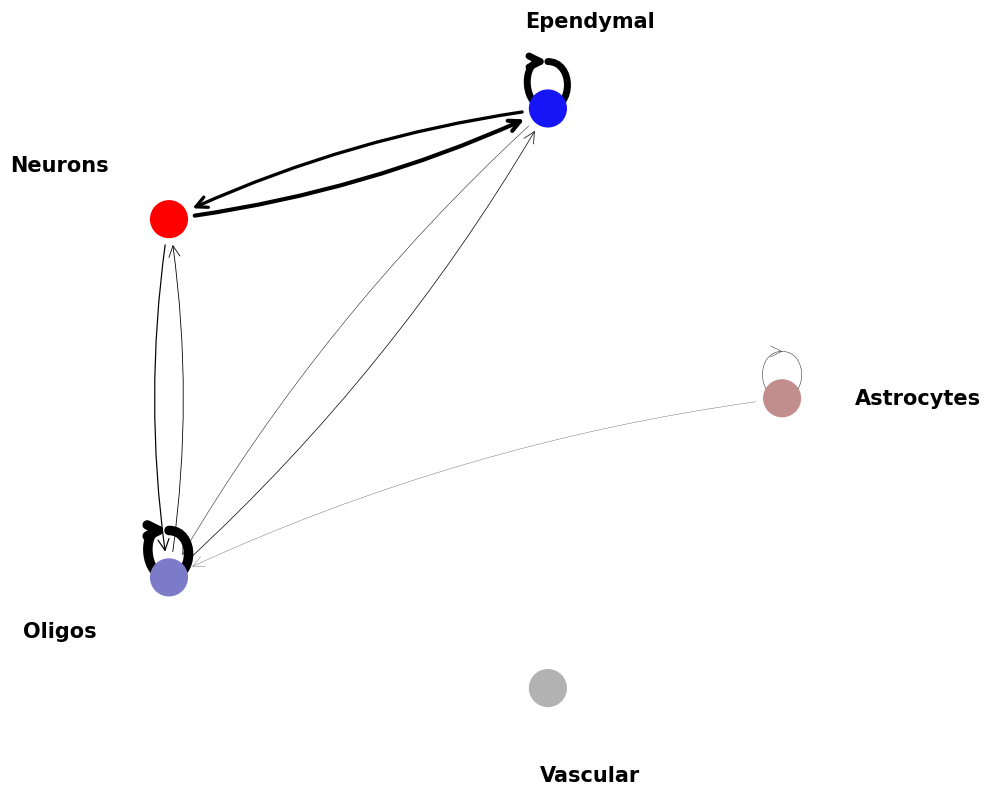


cluster3: Contains 20 LR pairs


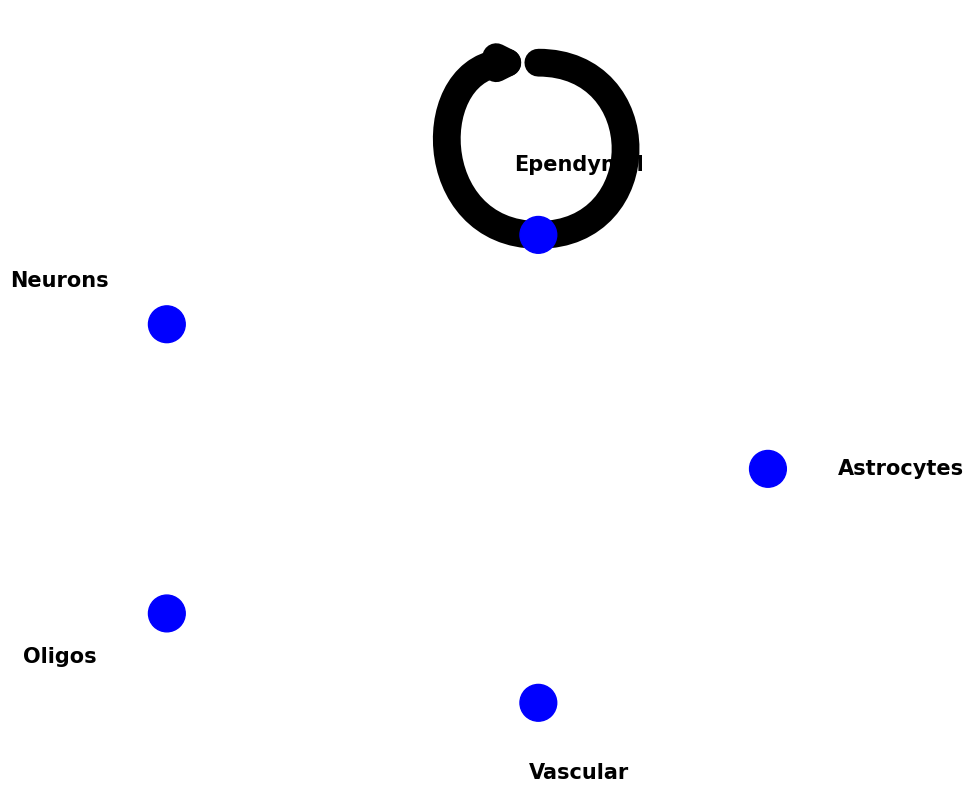


cluster4: Contains 10 LR pairs


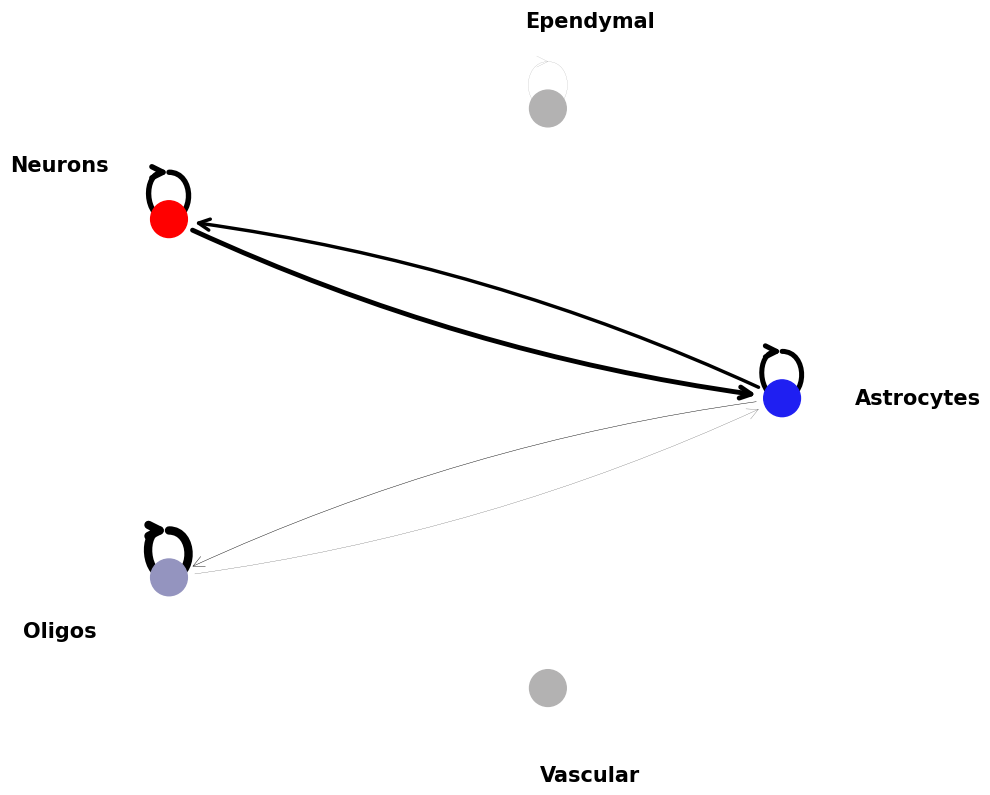


cluster5: Contains 24 LR pairs


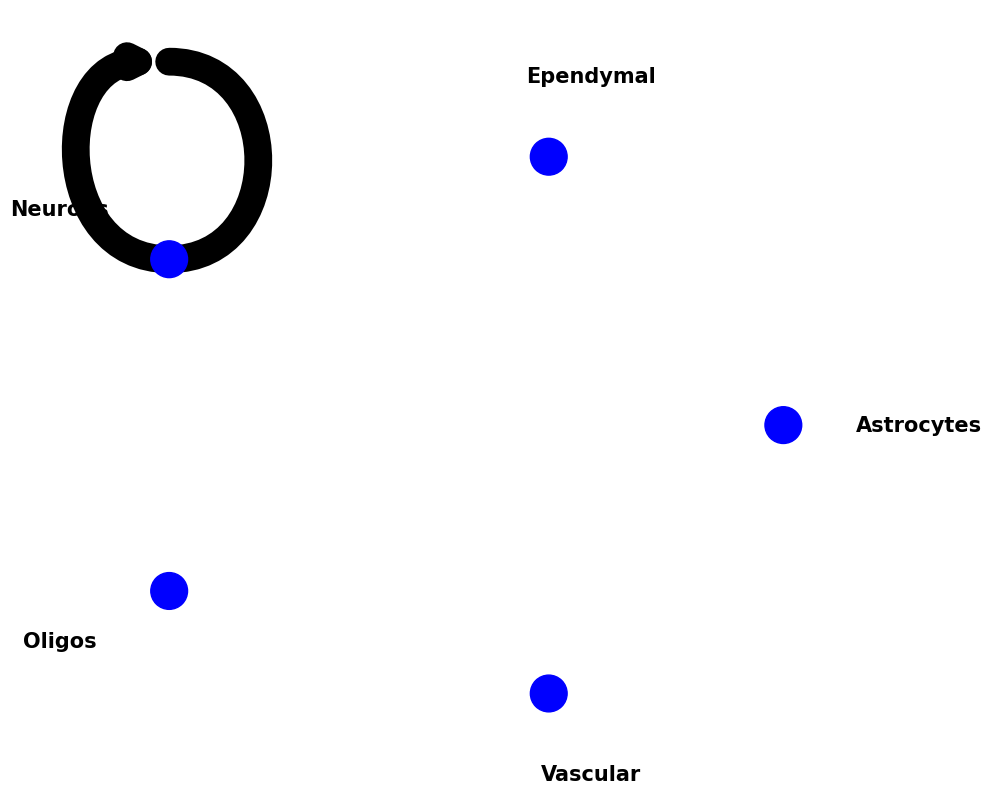


cluster6: Contains 14 LR pairs


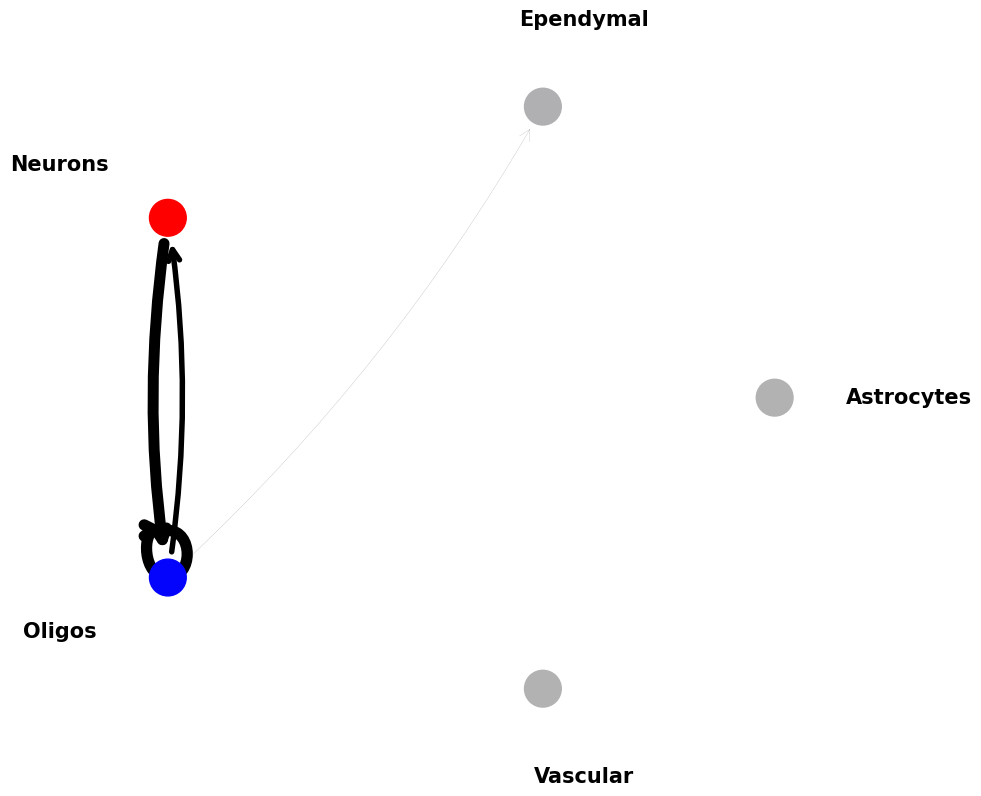


cluster7: Contains 14 LR pairs


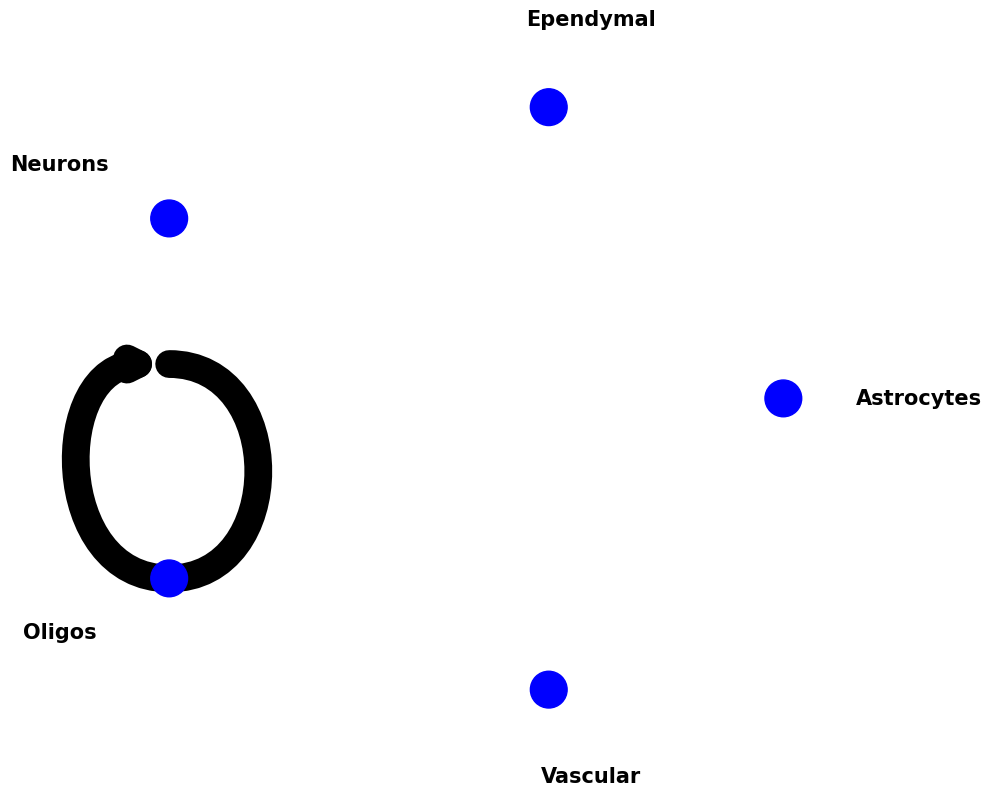


cluster8: Contains 20 LR pairs


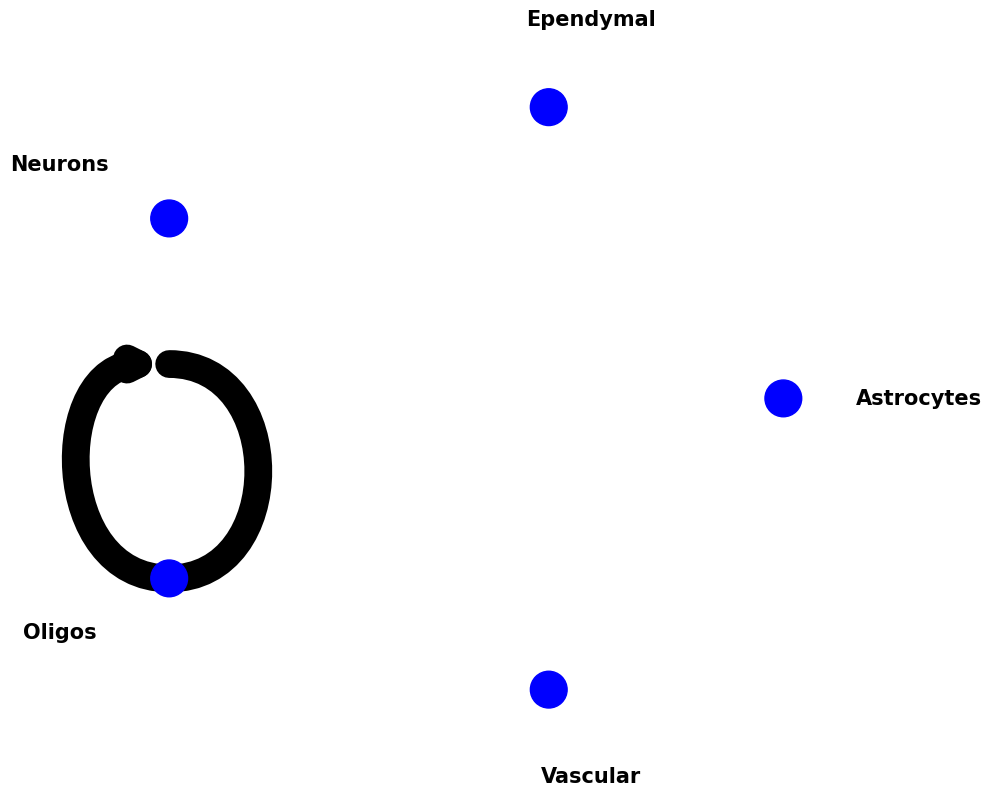


cluster9: Contains 21 LR pairs


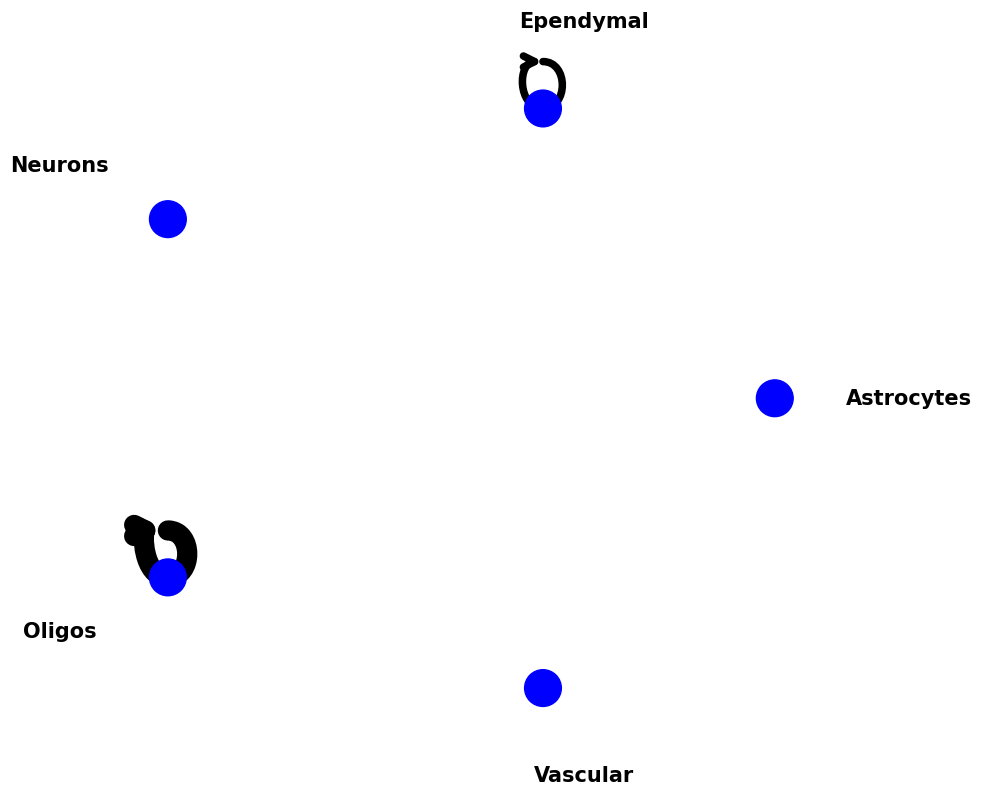

In [17]:
for cluster, matrix in young_overall_clusters.items():
    if matrix is not None:
        print("\ncluster" + str(cluster) + ": Contains " + str(len(young_integrated_clusters[cluster])) + " LR pairs")
        mmcci.plt.network_plot(matrix)